In [1]:
#Importing packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import netCDF4
import numpy as np
import calendar
import pandas as pd
import xarray as xr
import shapely.geometry as sgeom
import os.path
import collections
import datetime
import netCDF4
import cftime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,  LATITUDE_FORMATTER
from datetime import timedelta
from IPython.display import HTML
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import netCDF4
import numpy as np
import calendar
import pandas as pd
import xarray as xr
import shapely.geometry as sgeom
import os.path
import collections
import datetime
import netCDF4
import cftime
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,  LATITUDE_FORMATTER
from datetime import timedelta
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
import seaborn as sns
import h5py
import preprocessing as pre

#Store model observations on storms as a named tuple (enabling access to storm observational data via name instead of position index)

Observation = collections.namedtuple('Observation', ['date', 'lat', 'lon', 'vort', 'vmax', 
                                                     'mslp', 't63_850', 't63_700', 't63_600', 't63_500', 't63_250', 't63_850_250_diff', 'sfcWind', 'lat_sfcWind' , 'lon_sfcWind','extras'])

class obs(Observation):
    """  Represents a single observation of a model tropical storm. """
    def __init__(self, date, lat, lon, vmax, sfcWind, lat_sfcWind , lon_sfcWind , rv850_t63=-99.9, rv700_t63=-99.9, rv600_t63=-99.9, rv500_t63=-99.9, rv250_t63=-99.9, rv_diff_850_250=-99.9, extras=None, psl=-99.9):
        self.date = date
        self.lat = lat
        self.lon = lon
        self.vmax = vmax
        self.rv850_t63 = rv850_t63
        self.rv700_t63 = rv700_t63
        self.rv600_t63 = rv600_t63
        self.rv500_t63 = rv500_t63
        self.rv250_t63 = rv250_t63
        self.rv_diff_850_250 = rv_diff_850_250
        self.wind_speed = sfcWind
        self.lat_sfcWind = lat_sfcWind
        self.lon_sfcWind = lon_sfcWind
        self.extras = extras or {}

        
        
    def six_hourly_timestep(self):
        """ Returns True if a storm record is taken at 00, 06, 12 or 18Z only """
        return self.date.hour in (0, 6, 12, 18) and self.date.minute == 0 and self.date.second == 0
    
    def add_to_axes(self, ax):
        """ Instructions on how to plot a model tropical storm observation """
        ax.plot(self.lon, self.lat)

#Store information about the model storm (such as its storm number) and corresponding observations. 
#Additional information for a storm will be stored in extras as a dictionary

class Storm(object):
    
    @property
    def vmax(self):
        # The maximum wind speed attained by the storm during its lifetime 
        return max(ob.vmax for ob in self.obs)
    
    @property
    def mslp_min(self):
        # The minimum central pressure reached by the storm during its lifetime (set to -999 if no records are available) 
        mslps = [ob.mslp for ob in self.obs if ob.mslp != 1e12]  
        if not mslps:
            mslps = [-999]
        return min(mslps)
    
    @property
    def vort_max(self):
        # The maximum 850 hPa relative vorticity attained by the storm during its lifetime 
        return max(ob.vort for ob in self.obs)
    
    @property
    def t63_850_max(self):
        # The maximum T63 850 vorticity attained by the storm during its lifetime 
        return max(ob.t63_850 for ob in self.obs)
    
    @property
    def t63_250_max(self):
        # The maximum T63 250 vorticity attained by the storm during its lifetime 
        return max(ob.t63_250 for ob in self.obs)
    
    @property
    def t63_850_250_diff_max(self):
        # The maximum T63 850 - 250 vorticity attained by the storm during its lifetime 
        return max(ob.t63_850_250_diff for ob in self.obs)
    
    def __len__(self):
        # The total number of observations for the storm 
        return len(self.obs)
    
    def nrecords(self):
        # The total number of records/observations for the storm 
        return len(self)
    
    def number_in_season(self):
        # Returns storm number of the storm (the number of the storm for that year and ensemble member number) 
        return self.snbr    
    
    def lifetime(self):
        #The total length of time that the storm was active. This uses observation points with wind speeds greater than or equal to 34 knots.
        return max(ob.date for ob in self.obs)-min(ob.date for ob in self.obs)

            #obs_above_34 = [ob for ob in self.obs if ob.vmax >= 34]
        #if not obs_above_34:
            #return timedelta(0)
        #return max(ob.date for ob in obs_above_34) - min(ob.date for ob in obs_above_34)

        
    def genesis_date(self):
        # The first observation date that a storm becomes active 
        #return min(ob.date for ob in self.obs)
        return self.obs_at_genesis().date
    
    def lysis_date(self):
        # The final date that a storm was active 
        #return max(ob.date for ob in self.obs)
        return self.obs_at_lysis().date
    
    def ace_index(self):
        # The accumulated cyclone energy index for the storm. Calculated as the square of the storms maximum wind speed every 6 hours (0, 6, 12, 18Z) throughout its lifetime. Observations
        #of the storm taken in between these records are not currently used. Returns value rounded to
        #2 decimal places. Wind speed units: knots 
        ace_index = 0
        for ob in self.obs:
            if ob.six_hourly_timestep():
                ace_index += np.square(ob.extras['vmax_kts'])/10000.
        return round(ace_index, 2)
    
    def obs_at_vmax(self):
        #Return the maximum observed vmax Observation instance. If there is more than one obs at vmax then it returns the first instance 
        return max(self.obs, key=lambda ob: ob.vmax)
    
    def obs_at_vortmax(self):
        #Return the maximum observed vmax Observation instance. If there is more than one obs at vmax then it returns the first instance 
        return max(self.obs, key=lambda ob: ob.vort)
    
    def obs_at_mslpmin(self):
        #Return the maximum observed vmax Observation instance. If there is more than one obs at vmax then it returns the first instance 
        return min(self.obs, key=lambda ob: ob.mslp)
    
    def obs_at_genesis(self):
        #Returns the Observation instance for the first date that a storm becomes active       
        for ob in self.obs:
            return ob
        else:
            raise ValueError('model storm was never born :-(')

    def obs_at_lysis(self):
        #Returns the Observation instance for the last date that a storm was active    
        return [ob for ob in self.obs][-1]
    
    def _storm_vmax_in_basin(storm, basin):
        # Returns True if the maximum intensity of the storm occurred in desired ocean basin. 
        rbox = _basin_polygon(basin)  
        if 'obs_at_vmax' in dir(storm):
            xy = ccrs.PlateCarree().transform_point(storm.obs_at_vmax().lon, storm.obs_at_vmax().lat, ccrs.Geodetic())
        else:
            xy = ccrs.PlateCarree().transform_point(storm.obs_at_vmax().lon, storm.obs_at_vmax().lat, ccrs.Geodetic())
        point = sgeom.Point(xy[0], xy[1])
        if point.within(rbox):
            return True
        return False

    def __init__(self, snbr, obs, genesis_date, lifetime, extras=None):
        self.snbr = snbr
        self.obs = obs
        self.genesis_date = genesis_date
        self.lifetime = int(lifetime)
        self.lysis_date = genesis_date + datetime.timedelta(days=int(lifetime))
        

        # Create an empty dictionary if extras is undefined
        if extras is None:
            extras = {}
        self.extras = extras 

        # other methods here
    
    def __str__(self):
        #Returns a string representation of the Storm object
        #obs_above_34 = [ob for ob in self.obs if ob.vmax >= 34]
        return f"Storm {self.snbr} with {len(self.obs)} observations that began on {self.genesis_date.isoformat()}, ending on {self.lysis_date.isoformat()} lasting {self.lifetime} days."


'''
Load cmor netcdf format of track files
The input file should contain (at least):
Dimensions:
    ntracks: number of storms in file
    record: total number of time points
    plev: number of pressure levels (with associated data)
Variables:
    TRACK_ID(tracks): Storm number
    FIRST_PT(tracks): Index to first point in each storm
    NUM_PTS(tracks): The number of points in this storm
    index(record): storm track sequence number (index to this storm in the whole record diemsion)
    vortmean_T63(record): feature tracked variable
    lon(record): longitude of feature tracked variable
    lat(record): latitude of feature tracked variable
'''
def load_cmor(fh, vort_variable = ''):
    
    # final variables needed
    # storm number snbr
    # date, lat, long, vort, vmax, mslp, T63[nlev], vmax_kts, w10m

    scaling_ms_knots = 1.944
    print('fh type', type(fh))
    fh_type = str(type(fh))
    if 'str' in fh_type:
        fh = [fh]
    
    storm = []

    # for each file in the file handle            
    for fname in fh:
        if not os.path.exists(fname):
            raise Exception('Input file does not exist '+fname)
        else:
            print('fname ',fname)
            with netCDF4.Dataset(fname, 'r') as nc:
                track_algorithm = nc.getncattr('algorithm')
                if vort_variable == '':
                    if track_algorithm == 'TRACK':
                        if nc.getncattr('algorithm_extra') == 'T63avg':
                            vort_variable = 'vortmean_T63'
                        else:
                            vort_variable = 'rv850_T42'
                    elif track_algorithm == 'TempestExtremes':
                        vort_variable = 'rv850'

                # number of storms in the file
                ntracks = int(nc.dimensions['tracks'].size)
                try:
                    plev = int(nc.dimensions['plev'].size)
                except:
                    plev = 0

                variables = nc.variables
                # Loop through each storm, and create a class object containing the storm properties
                storms = []

                try:
                    psl = nc.variables['psl']
                    psl_var = 'psl'
                except:
                    psl = nc.variables['slp']
                    psl_var = 'slp'

                if psl.units == 'Pa':
                    psl_scaling = 1.0 / 100.0
                else:
                    psl_scaling = 1.0

                # read the time variable and convert to a more useful format
                time_var = nc.variables['time']
                dtime = cftime.num2date(time_var[:],time_var.units, calendar = time_var.calendar)
                

                first_pts = nc.variables['FIRST_PT'][:]
                storm_lengths = nc.variables['NUM_PTS'][:]
                indices = nc.variables['index'][:]
                lats = nc.variables['lat'][:]
                lons = nc.variables['lon'][:]
                

                try:
                    vorts = nc.variables[vort_variable][:]
                except:
                    vorts = np.ones(len(lons))

                psls = nc.variables[psl_var][:]
                sfcWinds = nc.variables['sfcWind'][:]
                lat_sfcWinds = nc.variables['lat_sfcWind'][:]
                lon_sfcWinds = nc.variables['lon_sfcWind'][:]

                if 'ws925' in variables:
                    vmaxs = nc.variables['ws925'][:]
                elif 'wind925' in variables:
                    vmaxs = nc.variables['wind925'][:]
                else:
                    vmaxs = np.ones(len(lons))
                
                # number of pressure levels for variables
                if plev >= 5:
                    rv850_T63 = nc.variables['rv850_T63'][:]
                    rv700_T63 = nc.variables['rv700_T63'][:]
                    rv600_T63 = nc.variables['rv600_T63'][:]
                    rv500_T63 = nc.variables['rv500_T63'][:]
                    rv250_T63 = nc.variables['rv250_T63'][:]
                    rv_diff_850_250 = (rv850_T63[:] - rv250_T63[:])
                elif plev > 0 and plev < 5:
                    rv850_T63 = nc.variables['rv850_T63'][:]
                    rv500_T63 = nc.variables['rv500_T63'][:]
                    rv250_T63 = nc.variables['rv250_T63'][:]
                    rv_diff_850_250 = (rv850_T63[:] - rv250_T63[:])
                elif plev == 0:
                    rv850_T63 = np.ones(len(lons))
                    rv500_T63 = np.ones(len(lons))
                    rv250_T63 = np.ones(len(lons))
                    rv_diff_850_250 = np.ones(len(lons))

                for storm_no in range(ntracks):
                    storm_obs = []
                    tcid = storm_no
                    
                    # Get storm information
                    first_pt = first_pts[storm_no]
                    storm_length = storm_lengths[storm_no]
                    record_no = storm_length
                    index = indices[first_pt:first_pt+storm_length]
                    
                    # Get genesis date
                    genesis_date = dtime[first_pt]
                    
                    # Get lifetime
                    lifetime = storm_length/4

                    

                    for ip in index:
                        i = ip+first_pt
                        date = dtime[i]
                        
                        lat = lats[i]
                        lon = lons[i]
                        vort = vorts[i]
                        psl = psls[i] * psl_scaling
                        sfcWind = sfcWinds[i]
                        lat_sfcWind = lat_sfcWinds[i]
                        lon_sfcWind = lon_sfcWinds[i]
                        vmax = vmaxs[i]
                        vmax_kts = vmax * scaling_ms_knots

                        rv850_t63_this = rv850_T63[i]
                        rv500_t63_this = rv500_T63[i]
                        rv250_t63_this = rv250_T63[i]
                        rv_diff_850_250_this = rv_diff_850_250[i]
                        
                        # Get RV700 and RV600 only if plev is greater than or equal to 5
                        if plev >= 5:
                            rv700_t63_this = rv700_T63[i]
                            rv600_t63_this = rv600_T63[i]
                        else:
                            rv700_t63_this = -99.9
                            rv600_t63_this = -99.9
                            
                        # Create an observation object
                        obs = Observation(date, lat, lon, vort, vmax, psl, rv850_t63_this, rv700_t63_this, rv600_t63_this, rv500_t63_this, rv250_t63_this, rv_diff_850_250_this, sfcWind, lat_sfcWind, lon_sfcWind, extras={'vmax_kts':vmax_kts})
                        
                        # Add observation to list of storm observations
                        storm_obs.append(obs)
                    
                    # Create a Storm object
                    storm = Storm(tcid, storm_obs, genesis_date, lifetime)
                    
                    # Add Storm object to list of storms
                    storms.append(storm)

            # Yield storm
                    yield Storm(tcid, storm_obs, genesis_date, lifetime, extras={})
months_sh = [10,11,12,1,2,3,4,5]
months_nh = [5,6,7,8,9,10,11]

basin_bounds = {'na': (-105, 0, 60, 0),
                'ep': (-170, -80, 40, 0),
                'wp': (-265, -180, 50, 0),
                'cp': (-180, -140, 50, 0),
                'ni': (-310, -260, 30, 0),
                'si': (-340, -260, 0, -40),
                'au': (-270, -195, 0, -40),
                'sp': (-200, -100, 0, -40),
                'nh': (-360, 30, 70, 0),
                'sh': (-360, 30, 0, -90),
                None: (-360, 0, 90, -90)
                }

def read_storms_filtered(file_path, hemi, basin):
    """
    For a given file path, read the storms from the file.
    """

    # Read the netcdf file
    storms = list(load_cmor(file_path))

    # Check the metadata to discover which algorithm this is, and hence
    # what feature variable is tracked
    with netCDF4.Dataset(file_path, 'r') as nc:
        track_algorithm = nc.getncattr('algorithm')
        if track_algorithm == 'TRACK':
            track_extra = nc.getncattr('algorithm_extra')
            if track_extra == 'T63avg':
                feature_variable = 'vortmean_T63'
            else:
                feature_variable = 'rv850_T42'
        elif track_algorithm == 'TempestExtremes':
            feature_variable = 'psl'
        else:
            raise Exception('Unrecognised algorithm in netcdf file '+file_path)

    if hemi.lower() == 'nh':
        months = months_nh
        lat_min, lat_max, lon_min, lon_max = basin_bounds[basin]
    elif hemi.lower() == 'sh':
        months = months_sh
        lat_min, lat_max, lon_min, lon_max = basin_bounds[basin]
    else:
        raise ValueError('Invalid hemisphere argument. Must be "NH" or "SH"')

    # Filter out storms that do not meet the specified criteria
    filtered_storms = []
    for storm in storms:
        if storm._storm_vmax_in_basin(basin):
            filtered_storms.append(storm)

    return filtered_storms, feature_variable, months
def read_storms(file_path, hemi):
    """
    For a given file path, read the storms from the file.
    """

    # Read the netcdf file
    storms = list(load_cmor(file_path))

    # Check the metadata to discover which algorithm this is, and hence
    # what feature variable is tracked
    with netCDF4.Dataset(file_path, 'r') as nc:
        track_algorithm = nc.getncattr('algorithm')
        if track_algorithm == 'TRACK':
            track_extra = nc.getncattr('algorithm_extra')
            if track_extra == 'T63avg':
                feature_variable = 'vortmean_T63'
            else:
                feature_variable = 'rv850_T42'
        elif track_algorithm == 'TempestExtremes':
            feature_variable = 'psl'
        else:
            raise Exception('Unrecognised algorithm in netcdf file '+file_path)

    if hemi.lower() == 'nh':
        months = months_nh
    elif hemi.lower() == 'sh':
        months = months_sh
    else:
        raise ValueError('Invalid hemisphere argument. Must be "NH" or "SH"')

    return storms, feature_variable, months 
def _get_time_range(year, months):
    """ 
    Creates a start and end date (a datetime.date timestamp) for a 
    given year and a list of months. If the list of months overlaps into 
    the following year (for example [11,12,1,2,3,4]) then the end date 
    adds 1 to the original year 
    
    """
    start_date = datetime.datetime(year, months[0], 1)
    end_year = year
    end_month = months[-1]+1
    if months[-1]+1 < months[0] or months[-1]+1 == 13 or len(months) >= 12:
        end_year = year+1
    if months[-1]+1 == 13:
        end_month = 1
    end_date = datetime.datetime(end_year, end_month, 1)
    return start_date, end_date
                
        
def _storms_in_time_range(storms, year, months):
    """Returns a generator of storms that formed during the desired time period """
    start_date, end_date = _get_time_range(year, months)
    for storm in storms: 
        dt = datetime.datetime(2014, 10, 1, 0, 0)
        dt_no_leap = cftime.datetime(2014, 10, 1, 0, 0, calendar='noleap')       
        if (storm.genesis_date >= start_date) and (storm.genesis_date < end_date):
            yield storm

#: Corresponding full basin names for each abbreviation
BASIN_NAME = {'na': 'North Atlantic',
              'ep': 'Eastern Pacific',
              'wp': 'Western Pacific',
              'cp': 'Central Pacific',
              'ni': 'North Indian Ocean',
              'si': 'Southwest Indian Ocean',
              'au': 'Australian Region',
              'sp': 'South Pacific',
              'nh': 'Northern Hemisphere',
              'sh': 'Southern Hemisphere',
              None: 'Global'
              }

#: Lat/lon locations for each ocean basin for mapping. If set to 
#: None then it returns a global map
MAP_REGION = {'na': (-105, 0, 60, 0),
              'ep': (-170, -80, 40, 0),
              'wp': (-265, -180, 50, 0),
              'ni': (-310, -260, 30, 0),
              'si': (-340, -260, 0, -40),
              'au': (-270, -195, 0, -40),
              'sp': (-200, -100, 0, -40),
              'sa': ( -90, 0, 0, -40),
              'nh': (-360, 30, 70, 0),
              'sh': (-360, 30, 0, -90),
              None: (-360, 0, 90, -90)
              }

#: Lat/lon locations of tracking regions for each ocean basin. If None
#: then returns a region for the whole globe
TRACKING_REGION = {'na': ([-75, -20, -20, -80, -80, -100, -100, -75, -75], [0, 0, 60, 60, 40, 40, 20, 6, 0]),
                   'ep': ([-140, -75, -75, -100, -100, -140, -140], [0, 0, 6, 20, 30, 30, 0]),
                   #'wp': ([-260, -180, -180, -260, -260], [0, 0, 60, 60, 0]),
                   'wp': ([-260, -180, -180, -260, -260], [0, 0, 60, 60, 0]),
                   'cp': ([-180, -140, -140, -180, -180], [0, 0, 50, 50, 0]),
                   'ni': ([-320, -260, -260, -320, -320], [0, 0, 30, 30, 0]),
                   'si': ([-330, -270, -270, -330, -330], [-40, -40, 0, 0, -40]),
                   'au': ([-270, -200, -200, -270, -270], [-40, -40, 0, 0, -40]),
                   'sp': ([-200, -120, -120, -200, -200], [-40, -40, 0, 0, -40]),
                   'sa': ([-90, 0, 0, -90, -90], [-40, -40, 0, 0, -40]),
#                   'nh': ([-360, 0, 0, -360, -360],[0, 0, 90, 90 ,0]),
                   'nh': ([-359.9, 0, 0, -359.9, -359.9],[0, 0, 90, 90 ,0]),
#                   'sh': ([-360, 0, 0, -360, -360],[-90, -90, 0, 0 ,-90]),
                   'sh': ([-359.9, 0, 0, -359.9, -359.9],[-90, -90, 0, 0 ,-90]),
                   'mdr': ([-80, -20, -20, -80, -80], [10, 10, 20, 20, 10]),
                   None: ([-360, 0, 0, -360, -360],[-90, -90, 90, 90 ,-90])
                   }    

def _basin_polygon(basin, project=True):
    """ 
    Returns a polygon of the tracking region for a particular 
    ocean basin. i.e. a storm must pass through this region 
    in order to be retined. For example, if basin is set to 
    'au' then storms for the Australian region must pass
    through the area defined by -270 to -200W, 0 to -40S.
    
    """
    rbox = sgeom.Polygon(list(zip(*TRACKING_REGION.get(basin))))
    if project: 
        rbox = ccrs.PlateCarree().project_geometry(rbox, ccrs.PlateCarree())
    return rbox

#Function for plotting storm tracks, genesis locations, lysis locations or locations of max intensity that form a desired set of years, months, and ocean basis.
#Default plot is of the storm tracks
'''
 To get different plots set:
    Genesis plot: genesis=True
    Lysis plot: lysis=True
    Maximum intensity (location of max wind): 
    max_intensity=True
Basin options:
    None: Whole globe
    'na': North Atlantic
    'ep': Eastern Pacific
    'wp': Western Pacific
    'ni': North Indian Ocean
    'si': Southwest Indian Ocean
    'au': Australian Region
    'sp': South Pacific
months and years will obtain storms that formed within those time periods
basin will return storms that passed through the designated basin
'''

def storm_tracks(storms, years, months, basin, title, fig, ax, algorithm, hemi, genesis=False, lysis=False, max_intensity=False, warmcore = False, yoff=0.):
   
    count = 0
    for year in years:
        for storm in _storms_in_time_range(storms, year, months):
            if genesis:
                variable = 'Genesis'
                ax.plot(storm.obs_at_genesis().lon, storm.obs_at_genesis().lat,
                         'bo', markersize=3, transform=ccrs.Geodetic())

            elif lysis:
                variable = 'Lysis'
                ax.plot(storm.obs_at_lysis().lon, storm.obs_at_lysis().lat,
                         'go', markersize=3, transform=ccrs.Geodetic())

            elif max_intensity:
                variable = 'Maximum Intensity'
                ax.plot(storm.obs_at_vmax().lon, storm.obs_at_vmax().lat,
                         'ro', markersize=3, transform=ccrs.Geodetic())

            else:
                variable = 'Tracks'   
                ax.plot([ob.lon for ob in storm.obs], [ob.lat for ob in storm.obs],
                     linewidth=1.2, transform=ccrs.Geodetic())
            
            
            count += 1

    if count != 0:
        fig.gca().coastlines() 
        title1 = 'Model Tropical Storm %s\n %s (%s - %s) using %s \n %s' % \
                  (variable, BASIN_NAME.get(basin), str(years[0]), str(years[-1]), algorithm, title)
        print(title1)
        ax.set_title(title1, fontsize=12)
        #s = ('Total tropical storms for %s: %s' % (hemi, count))
        #fig.text(0.02, 0.09-yoff, s, ha='left', va='center', transform=plt.gca().transAxes)
           
    else:
        print('No storms found')

#Defines the map that I am plotting on 
def load_map1(basin=None):
    """ Produces map for desired ocean basins for plotting. """ 
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-70))
    if basin == None:
        ax.set_global()
    else:
        ax.set_extent(MAP_REGION.get(basin))
    resolution ='10m' # use '10m' for fine scale and '110m' for  coarse scale (default)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}    
    return ax
def load_map2(basin=None):
    """ Produces map for desired ocean basins for plotting. """ 
    ax = plt.axes(projection=ccrs.PlateCarree())
    if basin == None:
        ax.set_global()
    else:
        ax.set_extent(MAP_REGION.get(basin))
    resolution ='10m' # use '10m' for fine scale and '110m' for  coarse scale (default)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}    
    return ax
def load_map(basin=None, central_longitude=0):
    """Produces map for desired ocean basins for plotting."""
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))
    if basin == None:
        ax.set_global()
    else:
        ax.set_extent(MAP_REGION.get(basin))
    resolution ='10m' # use '10m' for fine scale and '110m' for  coarse scale (default)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'gray'}
    gl.ylabel_style = {'size': 14, 'color': 'gray'}    
    return ax

def work(runid_info, data_dir, yearstart, yearend, yearsplot, basin, algorithm, member_id):
    fig = plt.figure(figsize=(10,8), dpi=100)
    ax = load_map2(basin='si')
    ax.add_feature(cfeature.OCEAN)

    yoff = 0
    for hemi in ['nh', 'sh']:
        storms, feature_variable, track_extra = read_storms_filtered(data_dir, hemi, basin)

        if hemi == 'sh':
            yoff = 0.05

        if hemi.lower() == 'nh':
            months = months_nh
        elif hemi.lower() == 'sh':
            months = months_sh
        else:
            raise ValueError('Invalid hemisphere argument. Must be "NH" or "SH"')

        title = runid_info['model']+'-'+runid_info['resol']+', ' +runid_info['member_id']+', '+str(yearstart)+'-'+str(yearend)
        storm_tracks(storms, yearsplot, months, basin, title, fig, ax, algorithm, hemi, yoff=yoff, max_intensity = False, genesis = False)

    current_dir = os.getcwd()
    plt.rcParams.update({'font.size': 14})
    figname = os.path.join(current_dir, runid_info['model']+member_id+'.png')
    plt.savefig(figname)

    plt.show()

In [2]:
file_path = "D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc"

hemi = 'SH'  # or 'NH'

basin = 'si'
#control-1950
storms, feature_variable, months = pre.read_storms_filtered(file_path, hemi,basin)

fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc


In [3]:
experiment = 'control-1950'
YEARSTART = '1953'
YEAREND = '1953'
algorithm = 'TRACK'
YEARSTART = int(YEARSTART)
YEAREND = int(YEAREND)
yearsplot = list(range(YEARSTART, YEAREND+1))
    
institute = 'EC-Earth'
model = 'EC-Earth3P'
resol = 'HR'
model_grid = 'gr'
member_id = 'r1i1p2f1'

#Creating a directory with the storm track info from files

netcdf_directory = '/Volumes/maxone/Masters_Thesis/Data_For_Analysis/control-1950/EC-Earth_Consortium/EC-Earth3p-HR/r1i1p2f1/TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc'

Model Tropical Storm Tracks
 Southwest Indian Ocean (1953 - 1953) using TRACK 
 Test_Title


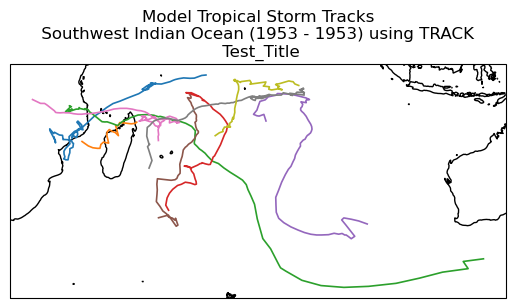

In [5]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

storm_tracks(storms,yearsplot,months,'si','Test_Title',fig,ax,algorithm,hemi)

TRACK
fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc


c:\Users\Nick\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Model Tropical Storm Tracks
 Southwest Indian Ocean (1953 - 1953) using TRACK 
 EC-Earth3P-HR, r1i1p2f1, 1953-1953
fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc
Model Tropical Storm Tracks
 Southwest Indian Ocean (1953 - 1953) using TRACK 
 EC-Earth3P-HR, r1i1p2f1, 1953-1953


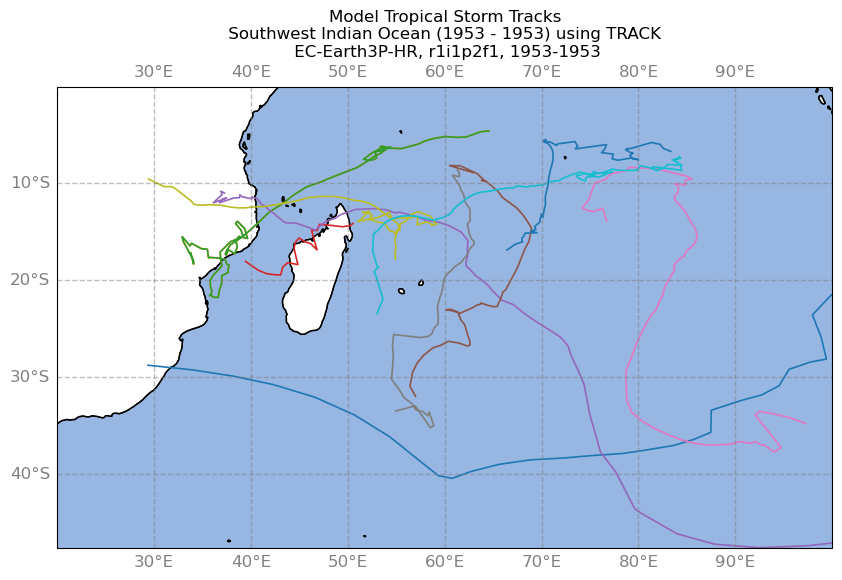

In [6]:
basin= 'si'
#Plotting my storm info 
runid_info = {'model': model, 'resol': resol, 'grid': model_grid, 'algorithm': algorithm, 'member_id':member_id}
runid_info2 = {'model': model, 'resol': resol, 'grid': model_grid, 'algorithm': algorithm, 'member_id':member_id}
dir_test = file_path
print(algorithm)


#work(runid_info,dir_test,YEARSTART,YEAREND,yearsplot,basin, algorithm, member_id)
work(runid_info2,dir_test,YEARSTART,YEAREND,yearsplot,basin,algorithm,member_id ) 

In [13]:
def read_storms_df(file_path, hemi):
    """
    For a given file path, read the storms from the file.
    """

    # Read the netcdf file & save info to storm and observation object classess
    storms = list(load_cmor(file_path))

    # Check the metadata to discover which algorithm this is, and hence
    # what feature variable is tracked
    with netCDF4.Dataset(file_path, 'r') as nc:
        track_algorithm = nc.getncattr('algorithm')
        if track_algorithm == 'TRACK':
            track_extra = nc.getncattr('algorithm_extra')
            if track_extra == 'T63avg':
                feature_variable = 'vortmean_T63'
            else:
                feature_variable = 'rv850_T42'
        elif track_algorithm == 'TempestExtremes':
            feature_variable = 'psl'
        else:
            raise Exception('Unrecognised algorithm in netcdf file '+file_path)

    if hemi.lower() == 'nh':
        months = months_nh
    elif hemi.lower() == 'sh':
        months = months_sh
    else:
        raise ValueError('Invalid hemisphere argument. Must be "NH" or "SH"')
        
    data = []
    for storm in storms:
        start_date = storm.genesis_date.strftime('%Y-%m-%d')
        end_date = storm.lysis_date.strftime('%Y-%m-%d')
        duration = (storm.lysis_date - storm.genesis_date).days
        intensity = np.max(storm.vmax)
        
        #psl = storm.obs.psl

        data.append({
        'year': storm.genesis_date.year,
        'storm_id': storm.snbr,
        'start_date': start_date,
        'end_date': end_date,
        'duration': duration,
        'intensity': intensity
        
        })
        
    df = pd.DataFrame(data)
    return df, feature_variable, months #obs.psl
def get_projected_track(storm, map_proj):
    """
    Project the storm track onto a map projection.

    Parameters
    ----------
    storm : Storm
        The storm to project.
    map_proj : cartopy.crs.Projection
        The projection to use.

    Returns
    -------
    projected_track : shapely.geometry.LineString
        The projected storm track.
    """
    lons, lats = list(zip(*[(ob.lon, ob.lat) for ob in storm.obs]))
    track = sgeom.LineString(list(zip(lons, lats)))
    projected_track = map_proj.project_geometry(track, ccrs.Geodetic())
    if isinstance(projected_track, sgeom.MultiLineString):
        projected_track = sgeom.LineString(projected_track[0].coords)
    else:
        projected_track = sgeom.LineString(projected_track.coords)
    return projected_track
def plot_windspeeds_and_track(file_path, hemi, storm_num):
    # Load the storms from the file and extract the feature variable
    storms, feature_variable, months = read_storms_filtered(file_path, hemi)
    storm = storms[storm_num]

    lon_indices = np.array([ob.lon_sfcWind for ob in storm.obs], dtype=np.int64)
    lat_indices = np.array([ob.lat_sfcWind for ob in storm.obs], dtype=np.int64)
    wind_speeds = np.array([ob.sfcWind for ob in storm.obs], dtype=np.float64)
    lon_indices, lat_indices, wind_speeds = np.broadcast_arrays(lon_indices, lat_indices, wind_speeds)

    # Get the projected track of the storm
    map_proj = ccrs.PlateCarree()
    projected_track = get_projected_track(storm, map_proj)

    # Create a plot of wind speeds along the track
    fig2, ax3 = plt.subplots(figsize=(10, 8))
    ax3.plot(np.arange(len(wind_speeds)), wind_speeds, color='blue')
    ax3.set_title('Wind Speeds Along Storm Track')
    ax3.set_xlabel('Time (steps)')
    ax3.set_ylabel('Wind Speed (mps)')

    # Create a plot of storm track with map projection
    fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={"projection": map_proj})
    ax.plot(projected_track.xy[0], projected_track.xy[1], color='black')
    ax.plot(projected_track.xy[0], projected_track.xy[1], 'ro')

    ax.set_title('Storm Track')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    for i, (x, y) in enumerate(zip(projected_track.xy[0], projected_track.xy[1])):
        if i % 4 == 0:
            dx = 0.05 * (projected_track.xy[0][-1] - projected_track.xy[0][0])
            dy = 0.05 * (projected_track.xy[1][-1] - projected_track.xy[1][0])
            ax.text(x + dx, y + dy, f"{wind_speeds[i]:.1f} mps", fontsize=10, color='black')
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.OCEAN)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'gray'}
    gl.ylabel_style = {'size': 12, 'color': 'gray'}
    
    plt.show()

def plot_storm(file_path, hemi, storm_num=200):
    # Load the storms from the file and extract the feature variable
    
    storms, feature_variable, months = read_storms(file_path, hemi)
    storm = storms[storm_num]
    obs = storm.obs

    # Get the lon, lat, and wind speed arrays
    lon_indices = np.array([ob.lon_sfcWind for ob in storm.obs], dtype=np.int64)
    lat_indices = np.array([ob.lat_sfcWind for ob in storm.obs], dtype=np.int64)
    wind_speeds = np.array([ob.sfcWind for ob in storm.obs], dtype=np.float64)
    lon_indices, lat_indices, wind_speeds = np.broadcast_arrays(lon_indices, lat_indices, wind_speeds)

    # Get the projected track of the storm
    map_proj = ccrs.PlateCarree()
    projected_track = get_projected_track(storm, map_proj)

    # Create a lineplot of wind speeds along the track
    fig2, ax3 = plt.subplots(figsize=(8, 6))
    ax3.plot(np.arange(len(wind_speeds)), wind_speeds, color='blue')
    #ax3.set_title('Wind Speeds Along Storm Track')
    ax3.set_xlabel('Time (steps)')
    ax3.set_ylabel('Wind Speed (m/s)')

    # Create a plot of storm track with map projection
    fig, ax = plt.subplots(figsize=(16, 12), subplot_kw={"projection": map_proj})
    ax.plot(projected_track.xy[0], projected_track.xy[1], color='black')
    ax.plot(projected_track.xy[0], projected_track.xy[1], 'ro')

    #ax.set_title('Storm Track')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    for i, (x, y) in enumerate(zip(projected_track.xy[0], projected_track.xy[1])):
        if i % 4 == 0:
            dx = 0.05 * (projected_track.xy[0][-1] - projected_track.xy[0][0])
            dy = 0.05 * (projected_track.xy[1][-1] - projected_track.xy[1][0])
            ax.text(x + dx, y + dy, f"{wind_speeds[i]:.1f} m/s", fontsize=10, color='black')
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.OCEAN)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 14, 'color': 'gray'}
    gl.ylabel_style = {'size': 14, 'color': 'gray'}
    plt.rcParams.update({'font.size': 14})
    return fig, ax, fig2, ax3

def plot_sfcWind_1day(plotMF, data, date):

    #Make a more efficient time
    newTime = pd.to_datetime(data.time.values)
    data['time'] = newTime.strftime('%Y-%m-%d')


    #Create a subset of data
    subset = data.sel(time=date)

    lats = subset.lat.values
    lons = subset.lon.values
    wind = subset.sfcWind.values
    
    
    #plot mean field
    
    if plotMF:
        fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=50)})
        extent = [-340, -260, 0, -40]
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    

        cf = plt.contourf(lons, lats, wind, transform=ccrs.PlateCarree())
        ax.coastlines()
        
        cbar = plt.colorbar(cf, extend='both', orientation='horizontal', shrink=0.6, pad=0.05, aspect=50)
        cbar.set_label('Mean Wind Speed')
       

        plt.title('Mean Wind Field') 

        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                          linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels= False
        gl.right_labels = False
        #gl.xlines = False
        #gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 12, 'color': 'gray'}
        gl.ylabel_style = {'size': 12, 'color': 'gray'}

def plot_sfcWind_alldays(plotMF, data, start_date, end_date):
    # Make a more efficient time
    newTime = pd.to_datetime(data.time.values)
    data['time'] = newTime.strftime('%Y-%m-%d')

    # Loop through dates
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    for date in dates:
        # Create a subset of data
        subset = data.sel(time=date.strftime('%Y-%m-%d'))

        lats = subset.lat.values
        lons = subset.lon.values
        wind = subset.sfcWind.values

        # Plot mean field
        if plotMF:
            fig, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=50)})
            extent = [-340, -260, 0, -40]
            ax.set_extent(extent, crs=ccrs.PlateCarree())

            cf = plt.contourf(lons, lats, wind, transform=ccrs.PlateCarree())
            ax.coastlines()

            cbar = plt.colorbar(cf, extend='both', orientation='horizontal', shrink=0.6, pad=0.05, aspect=50)
            cbar.set_label('Mean Wind Speed')

            plt.title(f'Mean Wind Field {date.strftime("%Y-%m-%d")}') 

            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                              linewidth=1, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels= False
            gl.right_labels = False
            #gl.xlines = False
            #gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
            #gl.xformatter = LONGITUDE_FORMATTER
            #gl.yformatter = LATITUDE_FORMATTER
            gl.xlabel_style = {'size': 12, 'color': 'gray'}
            gl.ylabel_style = {'size': 12, 'color': 'gray'}

def get_date_range(start_date, end_date):
    dates = []
    date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    while date <= end:
        dates.append(date.strftime("%Y-%m-%d"))
        date += timedelta(days=1)
    return dates

In [14]:
# Create an empty dictionary to hold the storm data
storm_data = {"storm_id": [], "genesis_date": [], "lysis_date": [], "lifetime": [], "vmax": [], "mslp": []}

# Loop over the filtered storms and add the relevant information to the dictionary
for storm in storms:
    storm_data["storm_id"].append(storm.snbr)
    storm_data["genesis_date"].append(storm.genesis_date)
    storm_data["lysis_date"].append(storm.lysis_date)
    storm_data["lifetime"].append(storm.lifetime)
    storm_data["vmax"].append(storm.vmax)
    storm_data["mslp"].append(storm.mslp_min)


# Create a DataFrame from the storm data dictionary
storm_df = pd.DataFrame(storm_data)

# Print the DataFrame
print(storm_df.loc[storm_df['storm_id'] == 3579])

     storm_id         genesis_date           lysis_date  lifetime       vmax  \
950      3579  2021-01-01 12:00:00  2021-01-12 12:00:00        11  21.499241   

           mslp  
950  1001.22998  


In [15]:
#Creating a dataframe out of the storm information
storms_df, feature_variable, months = pre.read_storms_df(file_path, hemi)

#showing the dataframe filtered for different criteria that I want
filtered_df = storms_df[(storms_df['year'] == 1953) & (storms_df['intensity'] > 45) ]
print(filtered_df)

print(storms_df.loc[200])

fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc
     year  storm_id  start_date    end_date  duration  intensity
168  1953       168  1953-03-06  1953-04-06        31  48.238571
177  1953       177  1953-03-31  1953-04-08         8  46.785660
185  1953       185  1953-05-03  1953-05-10         7  51.075642
188  1953       188  1953-05-17  1953-05-24         7  51.138641
190  1953       190  1953-06-18  1953-06-26         8  45.968071
197  1953       197  1953-09-09  1953-09-17         8  50.014210
year                1953
storm_id             200
start_date    1953-11-24
end_date      1953-12-18
duration              24
intensity      22.993099
Name: 200, dtype: object


fh type <class 'str'>
fname  D:\Masters_Thesis\Data_For_Analysis\control-1950\EC-Earth_Consortium\EC-Earth3p-HR\r1i1p2f1\TC-SH_TRACK_EC-Earth3P-HR_control-1950_r1i1p2f1_gr_19500101-20491231.nc


C:\Users\Nick\AppData\Local\Temp\ipykernel_26388\1702295255.py:72: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  projected_track = sgeom.LineString(projected_track[0].coords)
c:\Users\Nick\anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


(<Figure size 1600x1200 with 1 Axes>,
 <GeoAxesSubplot:xlabel='Longitude', ylabel='Latitude'>,
 <Figure size 800x600 with 1 Axes>,
 <AxesSubplot:xlabel='Time (steps)', ylabel='Wind Speed (m/s)'>)

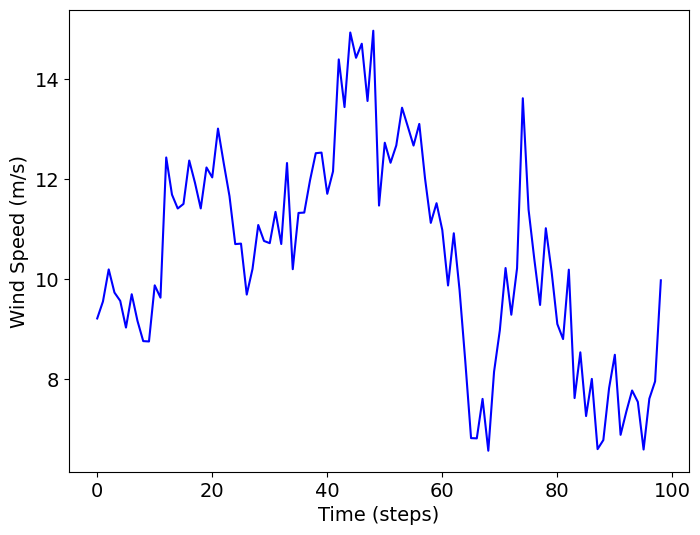

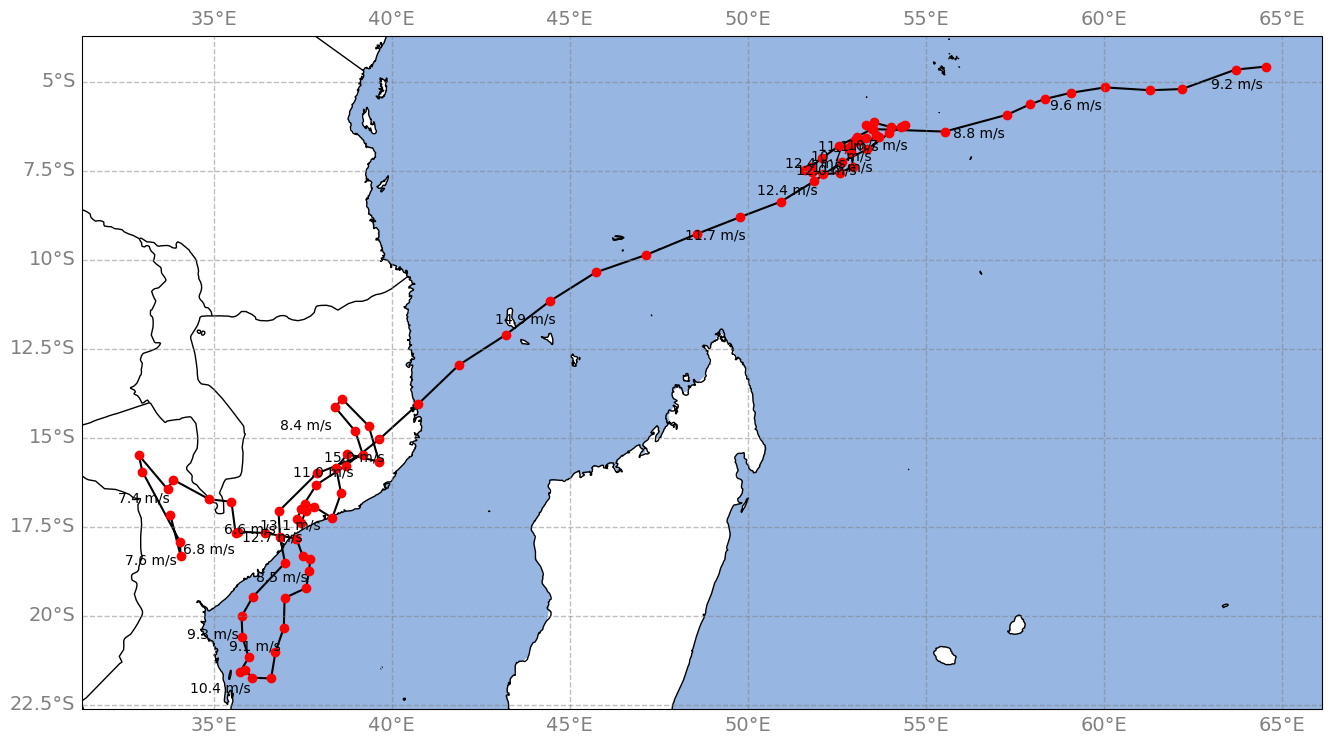

In [16]:
plot_storm(file_path, hemi, storm_num=200)